In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression

In [2]:
income = pd.read_csv('data/income.csv')
income['target'] = income.income.map({'<=50K': 0, '>50K': 1})
income.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K,0


In [3]:
nom_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']
num_features = ['educational-num']
target = 'target'
groups = ['age', 'race', 'gender']

In [4]:
preprocessing = ColumnTransformer(
    [('onehotencoder', OneHotEncoder(), nom_features),
     ('standardscaler', StandardScaler(), num_features)
     ])

income_train, income_test = train_test_split(income, test_size=0.2, random_state=42)

X_train = preprocessing.fit_transform(income_train).toarray()
y_train = income_train[target].to_numpy()
gender_train = income_train.gender.map({'Male': 0, 'Female': 1}).to_numpy()

X_test = preprocessing.transform(income_test).toarray()
y_test = income_test[target].to_numpy()
gender_test = income_test.gender.map({'Male': 0, 'Female': 1}).to_numpy()

print('Training data shape:', X_train.shape, '\ttarget shape:', y_train.shape)
print('Test data shape:', X_test.shape, '\t\ttarget shape:', y_test.shape)

Training data shape: (39073, 96) 	target shape: (39073,)
Test data shape: (9769, 96) 		target shape: (9769,)


In [5]:
logreg = LogisticRegression(max_iter=1000, random_state=42, penalty=None)
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.8394922714709796

In [6]:
class BinaryLogisticRegression(nn.Module):
    def __init__(self,
                 in_dim: int):
        super().__init__()
        
        self.layer = nn.Linear(in_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.layer(x)).flatten()

In [7]:

tensordata_train = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float(), torch.tensor(gender_train).float())
trainloader = DataLoader(tensordata_train, batch_size=64, shuffle=True)

X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [8]:
model = BinaryLogisticRegression(X_train.shape[1])

n_epochs = 10

loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

batch_losses = []
losses = []
val_losses = []
accs = []

for epoch in range(n_epochs):
    print(epoch)
    model.train()
    for x, y, gender in trainloader:
        b_size = x.size(0)
        
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    
    losses.append(np.mean(batch_losses[-b_size:]))
    
    model.eval()
    with torch.no_grad():
        y_hat = model(X_test)
        loss = loss_fn(y_hat, y_test)
        acc = accuracy_score(y_test.detach(), y_hat.detach().round())
        print('loss:', loss.item(), 'accuracy_score', acc)
        val_losses.append(loss.item())
        accs.append(acc)
        

0
loss: 0.3996248245239258 accuracy_score 0.8253659535264612
1
loss: 0.371258407831192 accuracy_score 0.8348858634455932
2
loss: 0.36333805322647095 accuracy_score 0.8375473436380387
3
loss: 0.36015674471855164 accuracy_score 0.8369331559013206
4
loss: 0.35869091749191284 accuracy_score 0.8379568021291841
5
loss: 0.35775062441825867 accuracy_score 0.8370355205241069
6
loss: 0.3573512136936188 accuracy_score 0.8386733544886887
7
loss: 0.35720115900039673 accuracy_score 0.8390828129798341
8
loss: 0.3571660816669464 accuracy_score 0.8394922714709796
9
loss: 0.35693907737731934 accuracy_score 0.839594636093766


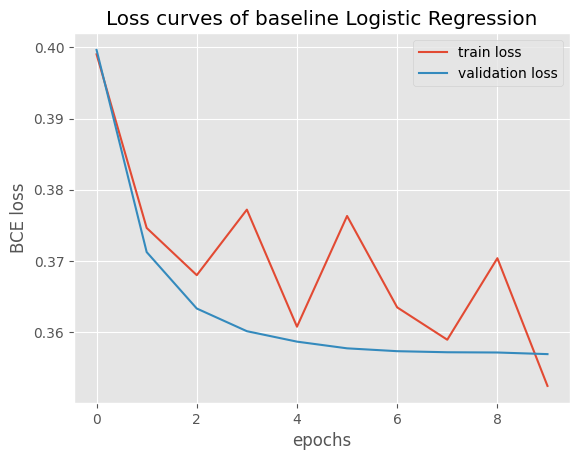

In [9]:
fig, ax = plt.subplots()
ax.plot(losses, label='train loss')
ax.plot(val_losses, label='validation loss')
ax.set_xlabel('epochs')
ax.set_ylabel('BCE loss')
ax.set_title('Loss curves of baseline Logistic Regression')
ax.legend()

In [10]:
preds = model(X_test).detach().numpy().round()
inv_preds = np.abs(preds - 1)
mask = gender_test == 0

In [11]:
print(accuracy_score(y_test.detach().numpy(), preds))
print(balanced_accuracy_score(y_test, preds))

print('Equalized odds:')
print('True case\t', preds[mask].sum() / mask.sum(), preds[~mask].sum() / (~mask).sum())
print('False case\t', inv_preds[mask].sum() / mask.sum(), inv_preds[~mask].sum() / (~mask).sum())

0.839594636093766
0.7370878342911827
Equalized odds:
True case	 0.24082322223928737 0.061694290976058934
False case	 0.7591767777607127 0.9383057090239411


To make models fair according to ***Equalized Odds***, we implement the group fairness constraint from:

Richard Berk, Hoda Heidari, Shahin Jabbari, Matthew Joseph, Michael Kearns, Jamie Morgenstern, Seth
Neel, and Aaron Roth. A convex framework for fair regression. arXiv preprint arXiv:1706.02409, 2017.

$$
f_2(\mathbf{w}, S)=\left(\frac{1}{n_1 n_2} \sum_{\substack{\left(\mathbf{x}_i, y_i\right) \in S_1 \\\left(\mathbf{x}_j, y_j\right) \in S_2}} d\left(y_i, y_j\right)\left(\mathbf{w} \cdot \mathbf{x}_i-\mathbf{w} \cdot \mathbf{x}_j\right)\right)^2
$$

This cost function does not work in our setting. We see that dividng by $n_1n_2$ before squaring leads to a tiny penalty, which has no effect on the classifier. Instead, we implement the loss as:

$$
f_2(\mathbf{w}, S)=\frac{1}{n_1 n_2} \left(\sum_{\substack{\left(\mathbf{x}_i, y_i\right) \in S_1 \\\left(\mathbf{x}_j, y_j\right) \in S_2}} d\left(y_i, y_j\right)\left(\mathbf{w} \cdot \mathbf{x}_i-\mathbf{w} \cdot \mathbf{x}_j\right)\right)^2
$$

In [12]:
class GroupFairnessConstraint(nn.Module):
    def __init__(self):
        super(GroupFairnessConstraint, self).__init__()
        
    
    def forward(self, y_pred, y_true, groups):
        mask = groups == 0
        S_pred_1, S_true_1 = y_pred[mask],  y_true[mask]
        S_pred_2, S_true_2 = y_pred[~mask], y_true[~mask]
        
        n_1 = S_pred_1.shape[0]
        n_2 = S_pred_2.shape[0]

        idx1 = torch.arange(n_1)
        idx2 = torch.arange(n_2)

        idx1 = idx1.view(-1, 1)
        idx2 = idx2.view(1, -1)

        idx1 = idx1.repeat(1, idx2.size(1))
        idx2 = idx2.repeat(idx1.size(0), 1)

        result = torch.stack((idx1, idx2), dim=2).view(-1, 2)
        idx1 = result[:, 0]
        idx2 = result[:, 1]
        
        vector = self.d(S_true_1[idx1], S_true_2[idx2]) * (S_pred_1[idx1] - S_pred_2[idx2])
        cost = vector.sum() ** 2
        cost = cost / (n_1*n_2)

        return cost
        
    def d(self, y_i, y_j):
        return (y_i == y_j).int()
    

In [13]:
model = BinaryLogisticRegression(X_train.shape[1])

n_epochs = 10

loss_fn = nn.BCELoss()

gamma = 0.1
fairness_penalty = GroupFairnessConstraint()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

batch_losses = []
losses = []
val_losses = []
accs = []

for epoch in range(n_epochs):
    print(epoch)
    model.train()
    for x, y, gender in trainloader:
        b_size = x.size(0)
        
        y_hat = model(x)
        loss = loss_fn(y_hat, y) + gamma * fairness_penalty(y_hat, y, gender)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    
    losses.append(np.mean(batch_losses[-b_size:]))
    
    model.eval()
    with torch.no_grad():
        y_hat = model(X_test)
        loss = loss_fn(y_hat, y_test) + gamma*fairness_penalty(y_hat, y_test, gender_test)
        acc = accuracy_score(y_test.detach(), y_hat.detach().round())
        print('loss:', loss.item(), 'accuracy_score', acc)
        val_losses.append(loss.item())
        accs.append(acc)

0
loss: 72.54751586914062 accuracy_score 0.7805302487460334
1
loss: 26.766307830810547 accuracy_score 0.7882075954550107
2
loss: 40.3596076965332 accuracy_score 0.8004913501893746
3
loss: 21.323612213134766 accuracy_score 0.8025386426451019
4
loss: 7.944929122924805 accuracy_score 0.7998771624526564
5
loss: 13.070347785949707 accuracy_score 0.8015149964172382
6
loss: 7.328364372253418 accuracy_score 0.80202681953117
7
loss: 10.127708435058594 accuracy_score 0.8048930289691882
8
loss: 40.486244201660156 accuracy_score 0.8149247620022521
9
loss: 5.316739559173584 accuracy_score 0.8144129388883202


In [14]:
preds = model(X_test).detach().numpy().round()
inv_preds = np.abs(preds - 1)
mask = gender_test == 0
print('Equalized odds:')
print('True case\t', preds[mask].sum() / mask.sum(), preds[~mask].sum() / (~mask).sum())
print('False case\t', inv_preds[mask].sum() / mask.sum(), inv_preds[~mask].sum() / (~mask).sum())

Equalized odds:
True case	 0.0958378129319613 0.04266421117249847
False case	 0.9041621870680387 0.9573357888275016


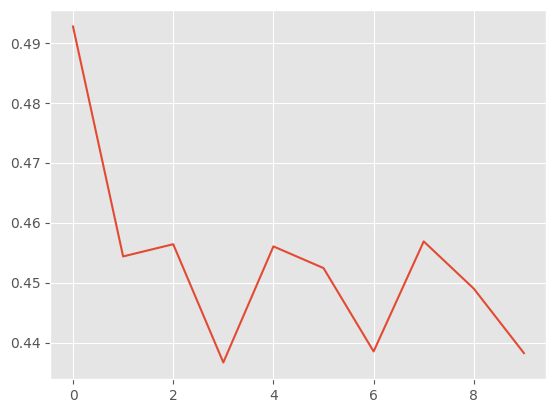

In [15]:
plt.plot(losses)